### Lennard-Jones melt

The `Lennard-Jones` melt, or commonly referred to as the `LJ` melt is hello world analog in Molecular Dynamics (MD). the simulation system consists of `N` particles interacting with each other via the `12-6` Lennard Jones potential given by

$$
U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12}  - \left(\frac{\sigma}{r}\right)^6\right]
$$

where

* $\epsilon$ is the interaction strength of the potential
* $\sigma$ is the interaction length scale (distance at which the $U(r) = 0$)
* $r$ is the radial distance between two interacting particles

This potential is quite frequently used in MD simulations when one wishes to implement simple pair wise, non-bonded interactions between particles. LJ potentials are widely used when studying coarse-grained polymer melts and nano-composites and are known to generate realisitc intermolecular interactions in MD systems.


Let's see the shape of the potential by simply plotting it for $\epsilon=1$ and $\sigma=1$. To do this we begin by defining an aribtrary potential class that is a `callable`

### Potentials

In [1]:
class Potential(object):
    """
    Base class for all MD potentials
    """
    def __init__(self, name: str):
        self.name = name

    def __call__(self, r: float):
        raise NotImplementedError

Now that we have created a `base` potential class, we now create the `LennardJones` potential class by subclassing it and providing an implementation for the `def __call__` method

In [3]:
class LennardJones(Potential):
    """
    Lennard Jones 12-6 potential class
    Input(s)
    epsilon = interaction strength
    sigma = potential interaction length scale
    cutoff = distance beyond which the potential is zero
    """
    def __init__(self, epsilon: float, sigma: float, cutoff: float = 2.5, name = "lj12/6"):
        self.epsilon = epsilon
        self.sigma = sigma
        self.cutoff = cutoff
        super().__init__(name=name)

    def __call__(self, r: float):
        """
        Compute the potential value given the distance `r`.
        The potential is set to 0 if r > cutoff
        """
        if r <= self.cutoff:
            return 4*self.epsilon*((self.sigma/r)**12 - (self.sigma/r)**6)
        return 0.0
    
class Harmonic(Potential):
    def __init__(self, k: float, r0: float, name="harmonic"):
        self.k = k
        self.r0 = r0
        super().__init__(name=name)
        
    def __call__(self, r: float):
        return 0.5*self.k*(r - self.r0)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations
from typing import List, Callable
from functools import partial
import covalent as ct
import numpy as np
import os
from shutil import rmtree
import re
import copy
from covalent import electron
from matplotlib.animation import FuncAnimation

#%matplotlib notebook

In [5]:
r = np.linspace(0.95, 3, 1000)
lj_potential = LennardJones(epsilon=1.0, sigma=1.0)

Ur = [lj_potential(value) for value in r]

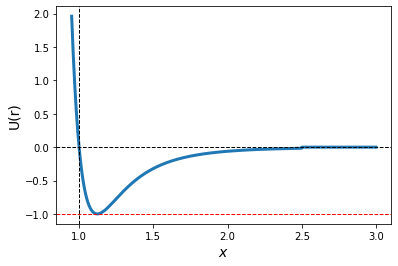

In [6]:
plt.plot(r, Ur, '-', lw=3)
plt.axhline(y = 0.0, linestyle='--', lw=1, color='k')
plt.axhline(y = -1.0, linestyle='--', lw=1, color='r')
plt.axvline(x=1.0, linestyle='--', lw=1, color='k')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'U(r)', fontsize=14)
plt.show()

### Forces

Once the interation potentials have been defined, the forces acting on the particles can be derived by taking its gradient

$$
\mathbf{F}(\mathbf{r}) = - \nabla U\left(\mathbf{r}\right)
$$

In a system of N particles, the force acting on the $i^{th}$ particle due to its interactions with every other particle in the system can be represented as

$$
\mathbf{F}_{i} = - \nabla_{\mathbf{r}_{i}} U\left(\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_N\right)
$$

In our case, since we know the functional, closed form of the Lennard Jones potential, we can simply differentiate it w.r.t to $r$ and derive a close for expression for the Lennard-Jones force. This can be expressed as

$$
\mathbf{F}(r) = - \frac{\partial U}{\partial r} = 48 \epsilon \left(\frac{\sigma^{12}}{r^{13}} - \frac{\sigma^6}{2 r^7}\right)
$$

and looks as follows for LJ, $\epsilon, \sigma = 1.0$

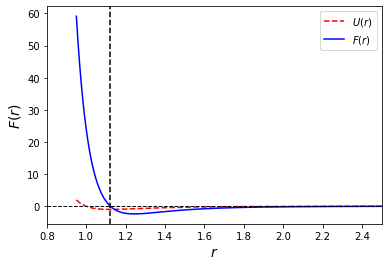

In [7]:
ljforce = lambda r: 48*(1.0/r**13 - 1.0/(2.0*r**7))


plt.plot(r, Ur, '--', color='r', label=r'$U(r)$')
plt.plot(r, ljforce(r), '-', color='b', label=r'$F(r)$')
plt.axhline(y=0.0, linestyle='--', color='k', lw=1)
plt.axvline(x=2**(1.0/6.0), linestyle='--', color='k')
plt.xlim([0.8, 2.5])
#plt.ylim([-3.0, 3])
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$F(r)$', fontsize=14)
plt.legend()
plt.show()
#|plt.tight_layout()

The minimum of the potential can be shown to be equal to $r_{0} = 2^{1/6} \sigma$ and we can see from the above figure that the force is negative i.e attractive. With this simple derivation we can see how the Lennard Jones potential can be used to represent interactions between particles in a MD simulation.

Generally speaking, computing the forces acting on particles becomes a trivial exercise when the closed form solution of the potential is known apriori. Generally speaking the potentials involved in large scale simulations are rather complicated and non-trivial to be expressed as closed form expressions. To simplify the situation in our case, we can simply numerically differentiate a given `Potential` object by using finite differences. There are several finite difference schemes available in practice, in this work we however use the `central difference` scheme to implement a generic MD force class that takes a potential as its input

Central differnce scheme
$$
\frac{d f}{dx} \approx \frac{f(x + \Delta) - f(x - \Delta)}{2\Delta}
$$
where $\Delta << 1 $ and is a small perturbation around $x$.

Using this, we can easily write down an expression that can yield the force acting on a particle given any object of type `Potential` as follows


```
force = -(Potential(r + Delta) - Potential(r - Delta))/(2*Delta)
```

Using such an expression will allow us to easily experiment with different potential types while not having to bother about writing the closed for expression of the force for each case. We create a `lambda` to convienietly compute the force at a given value of $r$ for any given object of type `Potential`

In [8]:
md_force = lambda r, potential: -(potential(r + 1e-8) - potential(r - 1e-8))/(2*(1e-8))

Deriving the force this way from the potential is of course an approximation and its accuracy can be compared against the true value in the Lennard Jones case.

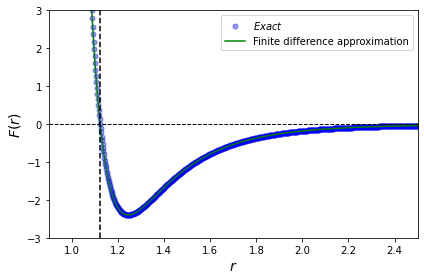

In [9]:
plt.plot(r, ljforce(r), 'o', ms=5, alpha=0.4, color='b', label=r'$Exact$')
approx = [md_force(value, LennardJones(epsilon=1.0, sigma=1.0)) for value in r]
plt.plot(r, approx, '-', color='g', label=r'Finite difference approximation')
plt.axhline(y=0.0, linestyle='--', color='k', lw=1)
plt.axvline(x=2**(1.0/6.0), linestyle='--', color='k')
plt.xlim([0.9, 2.5])
plt.ylim([-3.0, 3])
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$F(r)$', fontsize=14)
plt.legend()
plt.tight_layout()

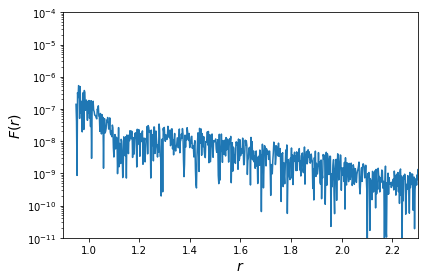

In [10]:
approx = np.asarray([md_force(value, LennardJones(epsilon=1.0, sigma=1.0)) for value in r])
plt.plot(r, np.abs(ljforce(r) - approx), '-')
plt.yscale('log')
plt.xlim([0.9, 2.3])
plt.ylim([10e-12, 10e-5])
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$F(r)$', fontsize=14)
plt.tight_layout()
plt.show()

### Simulation domain

We now build a class to represent the domain of our simulations with methods that facilitate querying the dimension of the domain quickly

In [11]:
class Domain(object):
    def __init__(self, xlo: float, xhi: float, ylo: float, yhi: float):
        self.xlo = xlo
        self.xhi = xhi
        self.ylo = ylo
        self.yhi = yhi

    @property
    def lx(self):
        return self.xhi - self.xlo

    @property
    def ly(self):
        return self.yhi - self.ylo

### Particle

To abstract and facilitiate computation, we create a base particle class whose instances reflect individual particle in the system being simulated. We initialize the particle velocities and forces to zero on creation and overload some `dunder` methods to faciliate computing differences between two particles, coverting particles to a string for saving their coordinates to files as well as comparing two particles with each other.

The `create_particle` is a helper method that simplifes the process of instantiating a particle object with coordinates sampled from a uniform distribution between [xlo, xhi], [ylo, yhi]

In [12]:
class Particle(object):
    def __init__(self, id: int, mass: float, x: float, y: float,
                 vx: float = 0.0, vy: float = 0.0, fx: float = 0.0,
                 fy: float = 0.0):
        """
        Basic particle
        """
        self.id = id
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = fx
        self.fy = fy

    def __eq__(self, other):
        return all([other.__dict__[key] == value for key, value in
                   self.__dict__.items()])

    def __sub__(self, other):
        return self.x - other.x, self.y - other.y

    def __repr__(self):
        return f"Particle(id={self.id}, mass={self.mass},x={self.x},\
                y={self.y},vx={self.vx},vy={self.vy},\
                fx={self.fx},fy={self.fy})".replace('\n', '')

    def __str__(self):
        return f"""{self.id},{self.mass},{self.x},{self.y},{self.vx},{self.vy},{self.fx},{self.fy}\n"""

def create_particle(id: int, mass: float, domain: Domain):
    """
    Create a particle with id=`id` and mass=`mass' randomly
    located in the domain
    """
    return Particle(id=id, mass=mass,
                    x=np.random.uniform(domain.xlo, domain.xhi),
                    y=np.random.uniform(domain.ylo, domain.yhi))

### Periodic boundary conditions and minimum image convention

To implement the minimum image convention, the `check_pbc` method, when invoked figures if the distance between two particles is greater than half the domain size, if so returns the appropriate distance between the particle and the nearest image

In [13]:
@ct.electron
def check_pbc(dx: float, L: float):
    if dx > L*0.5:
        return dx - L
    if dx <= -L*0.5:
        return dx + L
    return dx

### Total system potential energy

This is an important routine, that given a snapshot of the MD system i.e list of all particles return back the total potential energy of the configuration. As auxiliary variables, this method also takes in a reference to the instance of the potential and the simulation domain in order to effectivley compute the system's total PE

In [14]:
@ct.electron
def total_pe(particles: List[Particle], potential, domain: Domain):
    total = 0.0
    for i in particles:
        for j in particles:
            if i == j:
                continue
            else:
                dx, dy = i - j
                dx = check_pbc(dx, domain.lx)
                dy = check_pbc(dy, domain.ly)
                
                dr = np.sqrt(dx**2 + dy**2)
                total += potential(dr)
    return total/2.0

### Gradient of the total system potential energy

Given that we will be relaxing the system's initial configuration in order to minimize the total potential energy, the following `electron` computes the gradient of the same. Given a list of particles i.e. system configuration, the interaction potential and simulation domain this method using finite difference (forward difference) computes how system's total PE changes with respect to changes in each particle's positions

In [15]:
@ct.electron
def grad_pe(particles: List[Particle], potential, domain: Domain, epsilon: float = 1e-8):
    grad = []
    for p in particles:
        pe = total_pe(particles=particles, potential=potential, domain=domain)
        p.x += epsilon
        pe_delta = total_pe(particles=particles, potential=potential, domain=domain)
        dudpx = (pe_delta - pe)/epsilon
        p.x -= epsilon
        
        p.y += epsilon
        pe_delta = total_pe(particles=particles, potential=potential, domain=domain)
        dudpy = (pe_delta - pe)/epsilon
        p.y -= epsilon
        
        grad.append(dudpx)
        grad.append(dudpy)
        
    return grad

### Save particles to file
This `electron` saves snapshots of the system's configuration to file when invoked

In [16]:
@ct.electron
def save_snapshot(particles: List[Particle], step: int, path: str):
    if not os.path.isdir(f"{path}/snapshots"):
        os.mkdir(f"{path}/snapshots")
    dump_file=f"{path}/snapshots/system_{step}.txt"
    
    with open(dump_file, "w") as f:
        for particle in particles:
            f.write(str(particle))
        f.close()

### Gradient descent

This `electron` tries to minimize the total potential energy of the system by iteratively adjusting the coordinates of each particle such that the system's total PE decreases towards a minimum. As inputs it takes in an objective function (that needs to be minimized), list of particles, a routine that returns the `gradient` of the objective function, simulation domain and a dictionary of options

In [17]:
@ct.electron
def minimize_system_energy(objective, particles, grad, domain, options = {}, *args, **kwargs):
    """
    Given a system, minimize its potential energy using gradient descent
    """
    try:
        learning_rate = options["learning_rate"]
    except KeyError:
        learning_rate = 1e-3
        
    try:
        tol = options["tol"]
    except KeyError:
        tol = 1e-5
        
    try:
        maxiter = options["maxiter"]
    except KeyError:
        maxiter = 500
        
    try:
        verbose = options["verbose"]
    except KeyError:
        verbose = False
        
    
    x = copy.deepcopy(particles)
    fold = objective(x)
    i = 0
    diff = 1e10
    diff_history = [diff]
    f_history = [fold]
    dx = np.zeros(2*len(x))
        
    while i < maxiter and diff > tol:
        dx = -learning_rate*np.asarray(grad(x))
            
        for index, particle in enumerate(x):
            particle.x += dx[index]
            particle.y += dx[index+1]
                
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
                            
        fnew = objective(x)
        diff = np.abs(fnew - fold)
        fold = fnew
        diff_history.append(diff)
        f_history.append(fnew)
        
        if verbose:
            print(i, fnew)
                
        if i % 10 == 0:
            learning_rate /= 2
            
        i += 1
        
    return x, fnew, i

### Initialize particle velocities

After energy minimization, we give every particle in the system a velocity randomly sampled from a normal distribution with mean 0 and standard deviation 1

In [18]:
@ct.electron
def init_velocities(particles: List[Particle]):
    for particle in particles:
        particle.vx = np.random.randn()
        particle.vy = np.random.randn()
    return particles

### Update forces

This routine/`electron` updates the forces on each particle as a result of its interactions with all its neighbours and nearest images. The total force acting on a given particle is then accumulated and summed as the pair pairs change

In [19]:
@ct.electron
def update_forces(particles: List[Particle], potential: Potential, domain: Domain):
    #particles_copy = copy.deepcopy(particles)
    for i in particles:
        i.fx = 0.0
        i.fy = 0.0
        for j in particles:
            if i == j:
                continue
            else:
                dx, dy = i - j
                
                dx = check_pbc(dx, domain.lx)
                dy = check_pbc(dy, domain.ly)
                
                dr = np.sqrt(dx**2 + dy**2)
                
                f = -(potential(dr+1e-8) - potential(dr-1e-8))/(2*1e-8)
                
                fx = (dx/dr)*f
                fy = (dy/dr)*f
                
                i.fx += fx/2.0
                i.fy += fy/2.0
    return particles

### Velocity verlet integration

This is the main integrator used in our simulation run. It takes in a list of particles, a potential, simulation domain and a time step `dt`. Using these inputs the integrator, as per the `velocity verlet` scheme updates the particle's positions and velocities over a timestep `dt`

In [20]:
@ct.electron
def velocity_verlet_integration(particles: List[Particle], potential, domain, dt):
    particles = update_forces(particles, potential, domain)

    # Update positions
    for particle in particles:
        particle.x = particle.x + particle.vx*dt + (particle.fx/(2*particle.mass))*dt**2
        particle.y = particle.y + particle.vy*dt + (particle.fy/(2*particle.mass))*dt**2
        particle.x = particle.x%domain.lx
        particle.y = particle.y%domain.ly
        
    # Update forces
    particles_copy = update_forces(particles, potential, domain)
    
    # Update velocities
    for index, particle in enumerate(particles):
        particle.vx = particle.vx + dt*(particles_copy[index].fx+particle.fx)/(2*particle.mass)
        particle.vy = particle.vy + dt*(particles_copy[index].fy+particle.fy)/(2*particle.mass)
        
    return particles

### Integrate N times

This `electron` is a convenience wrapper around the Velocity verlet integration and loops the call in a for loop ranging `nsteps`. After each step/update this electron also saves a snapshot of the system to disk for later post processing

In [21]:
@ct.electron
def run(nsteps, particles: List[Particles], potential: Potential,
        domain: Domain, dt: float, path: str):
    for i in range(nsteps):
        particles = velocity_verlet_integration(particles=particles,
                                                potential=potential,
                                                domain=domain,
                                                dt=dt)
        
        save_snapshot(particles, i, path)
    return particles

### Entire MD workflow

As a last step, we tie all the electrons into the `simulation` workflow before submitting the task to `covalent`

In [22]:
@ct.lattice
def simulation(particles: List[Particle], domain: Domain, potential: Potential, nsteps, path):
    """
    run a basic MD particle simulation
    """
    i = 0
    # Compute the system initial potential energy
    f_old = total_pe(particles, potential, domain=domain)
    
    # Minimize system energy
    objective = partial(total_pe, potential=potential, domain=domain)
    gradient = partial(grad_pe, potential=potential, domain=domain)
    particles, _, _ = minimize_system_energy(objective, particles, gradient, domain,
                                                                     options={"maxiter": 200, "tol": 1e-5,
                                                                              "learning_rate": 1e-2,
                                                                              "verbose": True})
    
    
    # Initialize velocities
    particles = init_velocities(particles)
    
    # Integrate forward in time nsteps
    particles = run(nsteps=nsteps,
                    particles=particles,
                    potential=potential,
                    domain = domain,
                    dt=1e-2, path=path)
        

    return {"particles": particles, "iters": nsteps}

In [23]:
path_to_save = "/home/venkat/agnostiq-rpi-tutorials"
# Cleanup if this directory is already present
if os.path.isdir(f"{path_to_save}/snapshots"):
    rmtree(f"{path_to_save}/snapshots")
    
domain = Domain(xlo = 0, xhi = 20, ylo = 0, yhi = 20)
num_particles = 10
nsteps = 1000
particles = [create_particle(id=index, mass=1.0, domain = domain) for index in range(num_particles)]
potential = LennardJones(epsilon=1.0, sigma=1.0)

In [24]:
res = ct.dispatch_sync(simulation)(particles, domain, potential, nsteps, path_to_save)

In [25]:
res.result

{'particles': [Particle(id=0, mass=1.0,x=8.008772971229636,                y=11.015343850522651,vx=-0.1459195597653146,vy=-0.9980833564585402,                fx=0.0,fy=0.0),
  Particle(id=1, mass=1.0,x=10.718751636907745,                y=5.533528590061867,vx=-1.86912642405429,vy=-0.9836363828657936,                fx=0.18424082201557831,fy=0.24892832811391943),
  Particle(id=2, mass=1.0,x=11.790756903492206,                y=16.716408484591412,vx=0.005454021107184096,vy=0.6394345225446538,                fx=0.0,fy=0.0),
  Particle(id=3, mass=1.0,x=8.207139490190967,                y=5.16910120808526,vx=-0.9442318123685999,vy=-0.4907102939722132,                fx=0.0,fy=0.0),
  Particle(id=4, mass=1.0,x=14.699115279693501,                y=7.824091505555327,vx=1.3028338734677125,vy=0.3701874206920926,                fx=0.4134506356213943,fy=-3.4023048662684414),
  Particle(id=5, mass=1.0,x=14.571461151309807,                y=8.87456337518093,vx=-0.4488858575809016,vy=-0.5343746213905

In [26]:
%matplotlib notebook

In [27]:
def animate(frame_number):
    data = np.loadtxt(f"{path_to_save}/snapshots/system_{frame_number}.txt",
                      delimiter=",")
    x = data[:, 2]
    y = data[:, 3]
    line.set_data((x, y))
    return line

<IPython.core.display.Javascript object>


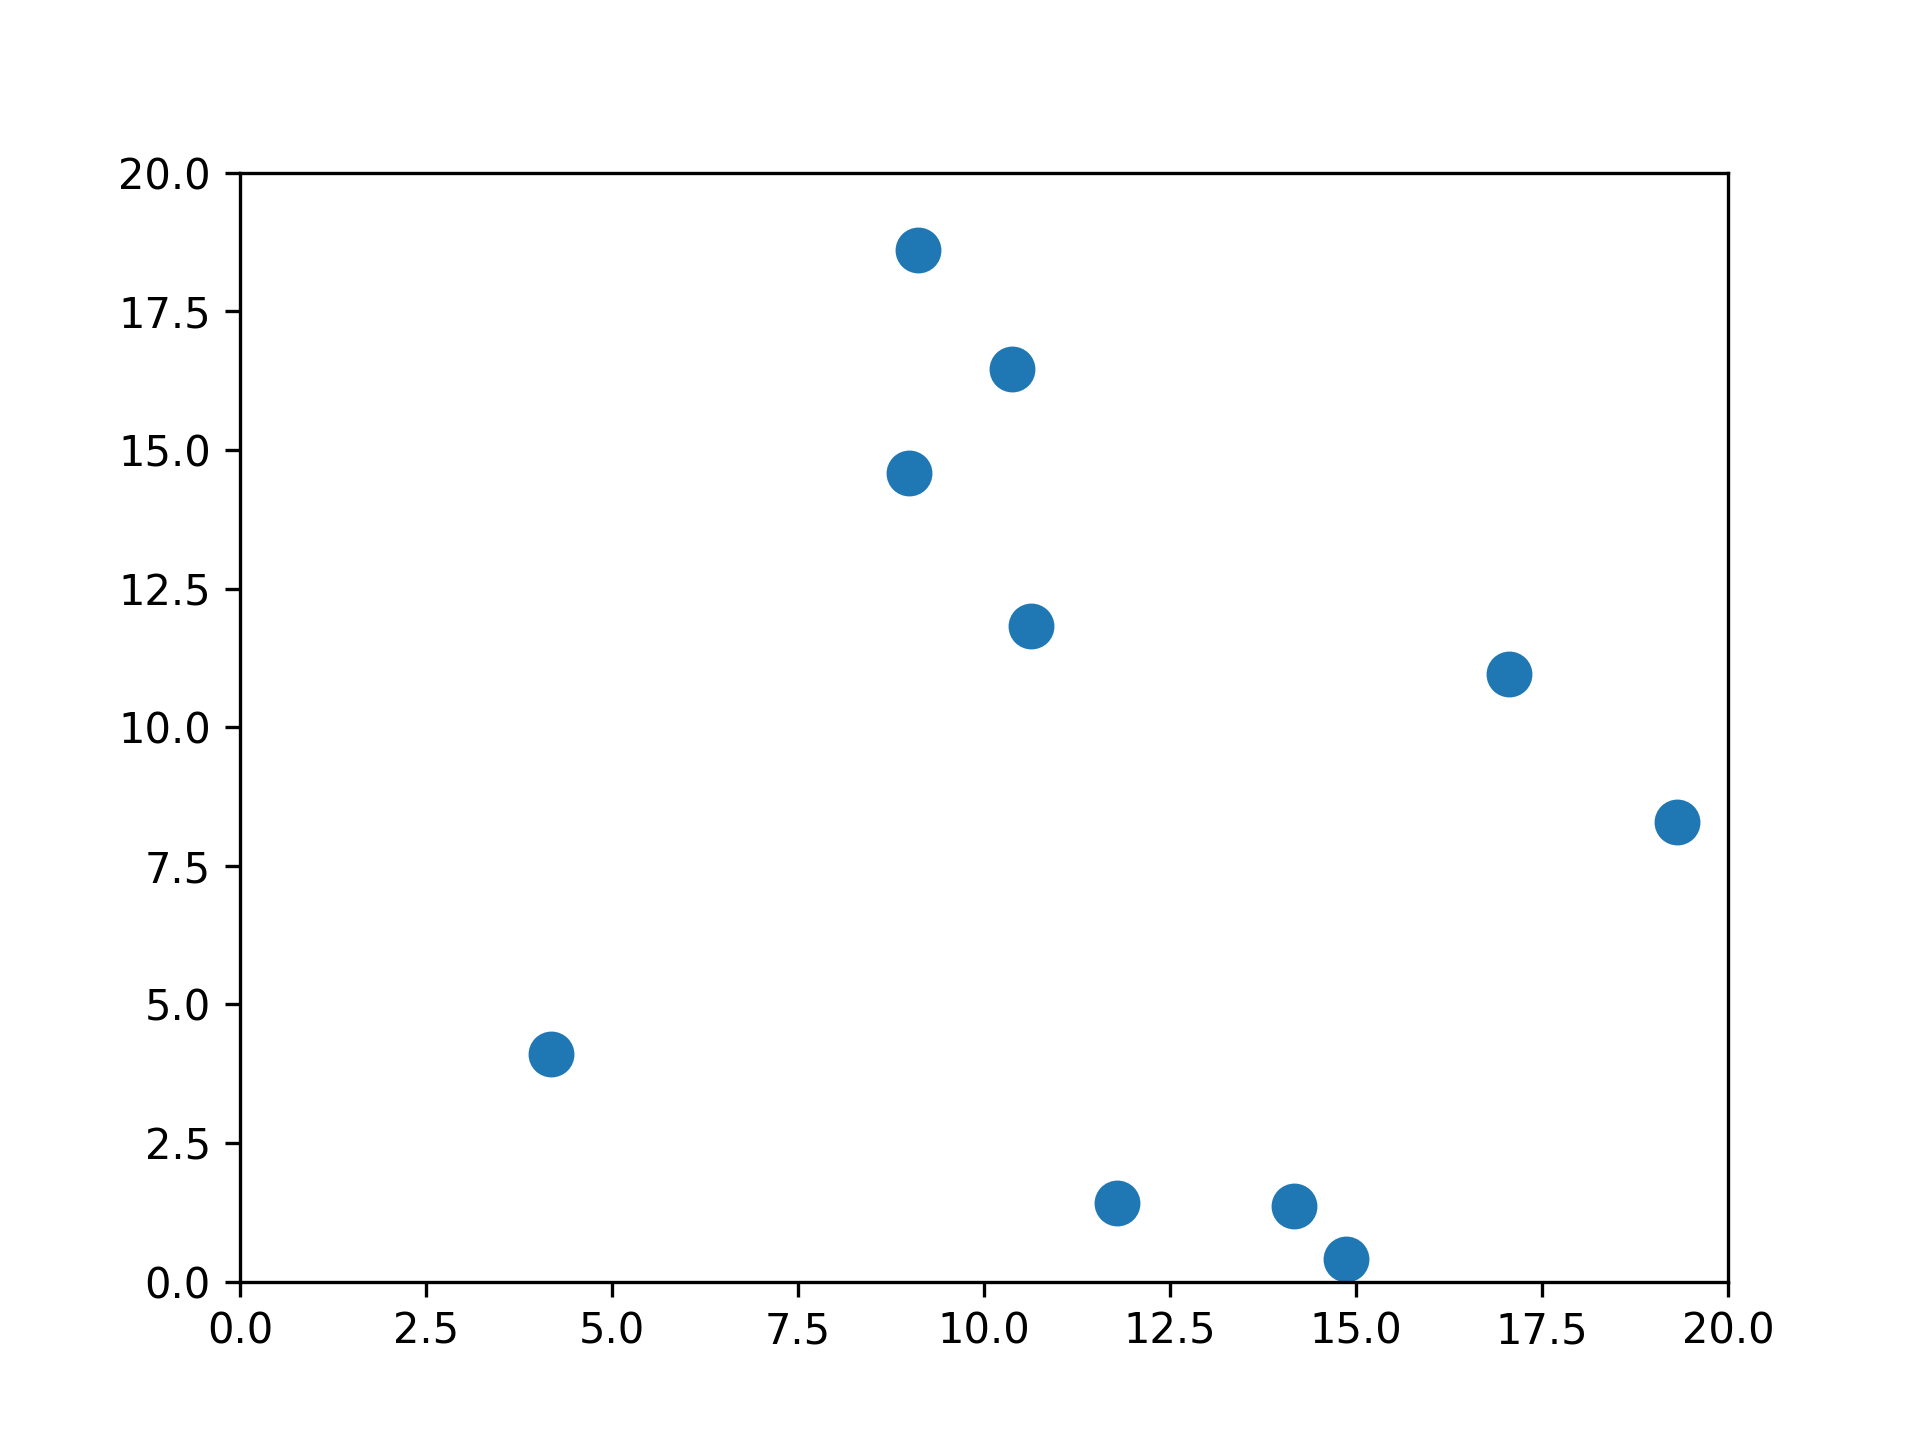

In [28]:
fig, ax = plt.subplots()

line, = ax.plot([], 'o', ms=10)     # A tuple unpacking to unpack the only plot
ax.set_xlim(domain.xlo, domain.xhi)
ax.set_ylim(domain.ylo, domain.yhi)

anim = FuncAnimation(fig, animate, frames=nsteps, interval=1)
#anim.save("test.mp4")
plt.show()